In [2]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "bird-speciees-dataset"

# **Import**

In [22]:
library(keras)
library(tensorflow)
library(tidyverse)
library(tfdatasets)
library(ggplot2)
library(caret)
library(imager)
library(pROC) 
library(grid)
library(gridExtra)

# **1. Data Import**

In [4]:
data_dir <- '/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset'

# **2. Data Transform & Visualization**

In [5]:
channels = 3 #RGB
batch_size <- 32
img_size <- c(224, 224)
num_classes <- 6

## **Train_Test_Split**

In [6]:
load_and_split_data <- function(data_dir, img_size, train_split = 0.8, val_split = 0.1) {
  categories <- list.dirs(data_dir, full.names = FALSE, recursive = FALSE)
  data <- data.frame()
  
  for (category in categories) {
    category_path <- file.path(data_dir, category)
    files <- list.files(category_path, pattern = "\\.jpg$", full.names = TRUE)
    labels <- rep(category, length(files))
    data <- rbind(data, data.frame(file_path = files, label = labels, stringsAsFactors = FALSE))
  }
  
  set.seed(123)
  data <- data[sample(nrow(data)), ]
  
  train_index <- 1:floor(train_split * nrow(data))
  val_index <- (max(train_index) + 1):floor((train_split + val_split) * nrow(data))
  test_index <- (max(val_index) + 1):nrow(data)
  
  list(
    train = data[train_index, ],
    val = data[val_index, ],
    test = data[test_index, ],
    all = data
  )
}

In [7]:
data_splits <- load_and_split_data(data_dir, img_size)

In [8]:
train_data <- data_splits$train
val_data <- data_splits$val
test_data <- data_splits$test
all_data <- data_splits$all

## **Data preprocessing**

In [9]:
image_generator <- image_data_generator(
  rescale = 1/255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = TRUE,
  fill_mode = 'nearest',
  brightness_range = c(0.8, 1.2)
)

train_gen <- flow_images_from_dataframe(
  train_data,
  x_col = "file_path",
  y_col = "label",
  target_size = img_size,
  batch_size = batch_size,
  class_mode = "categorical",
  generator = image_generator,
  shuffle = TRUE
)

val_gen <- flow_images_from_dataframe(
  val_data,
  x_col = "file_path",
  y_col = "label",
  target_size = img_size,
  batch_size = batch_size,
  class_mode = "categorical",
  generator = image_generator,
  shuffle = TRUE
)

test_gen <- flow_images_from_dataframe(
  test_data,
  x_col = "file_path",
  y_col = "label",
  target_size = img_size,
  batch_size = batch_size,
  class_mode = "categorical",
  generator = image_generator,
  shuffle = FALSE
)


class_counts <- table(train_data$label)
total_samples <- sum(class_counts)
class_weights <- list()
for (i in seq_along(class_counts)) {
  class_weights[[as.character(i - 1)]] <- total_samples / (num_classes * class_counts[i])
}
class_weights <- setNames(as.list(class_weights), 0:(num_classes - 1))

In [10]:
head(all_data)

,file_path,label
,<chr>,<chr>
415,/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset/DOWNY WOODPECKER/012.jpg,DOWNY WOODPECKER
463,/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset/DOWNY WOODPECKER/060.jpg,DOWNY WOODPECKER
179,/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset/BARN OWL/036.jpg,BARN OWL
526,/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset/DOWNY WOODPECKER/123.jpg,DOWNY WOODPECKER
195,/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset/BARN OWL/052.jpg,BARN OWL
118,/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/118.jpg,AMERICAN GOLDFINCH


## **Visuzlization**

### **CountPlot**

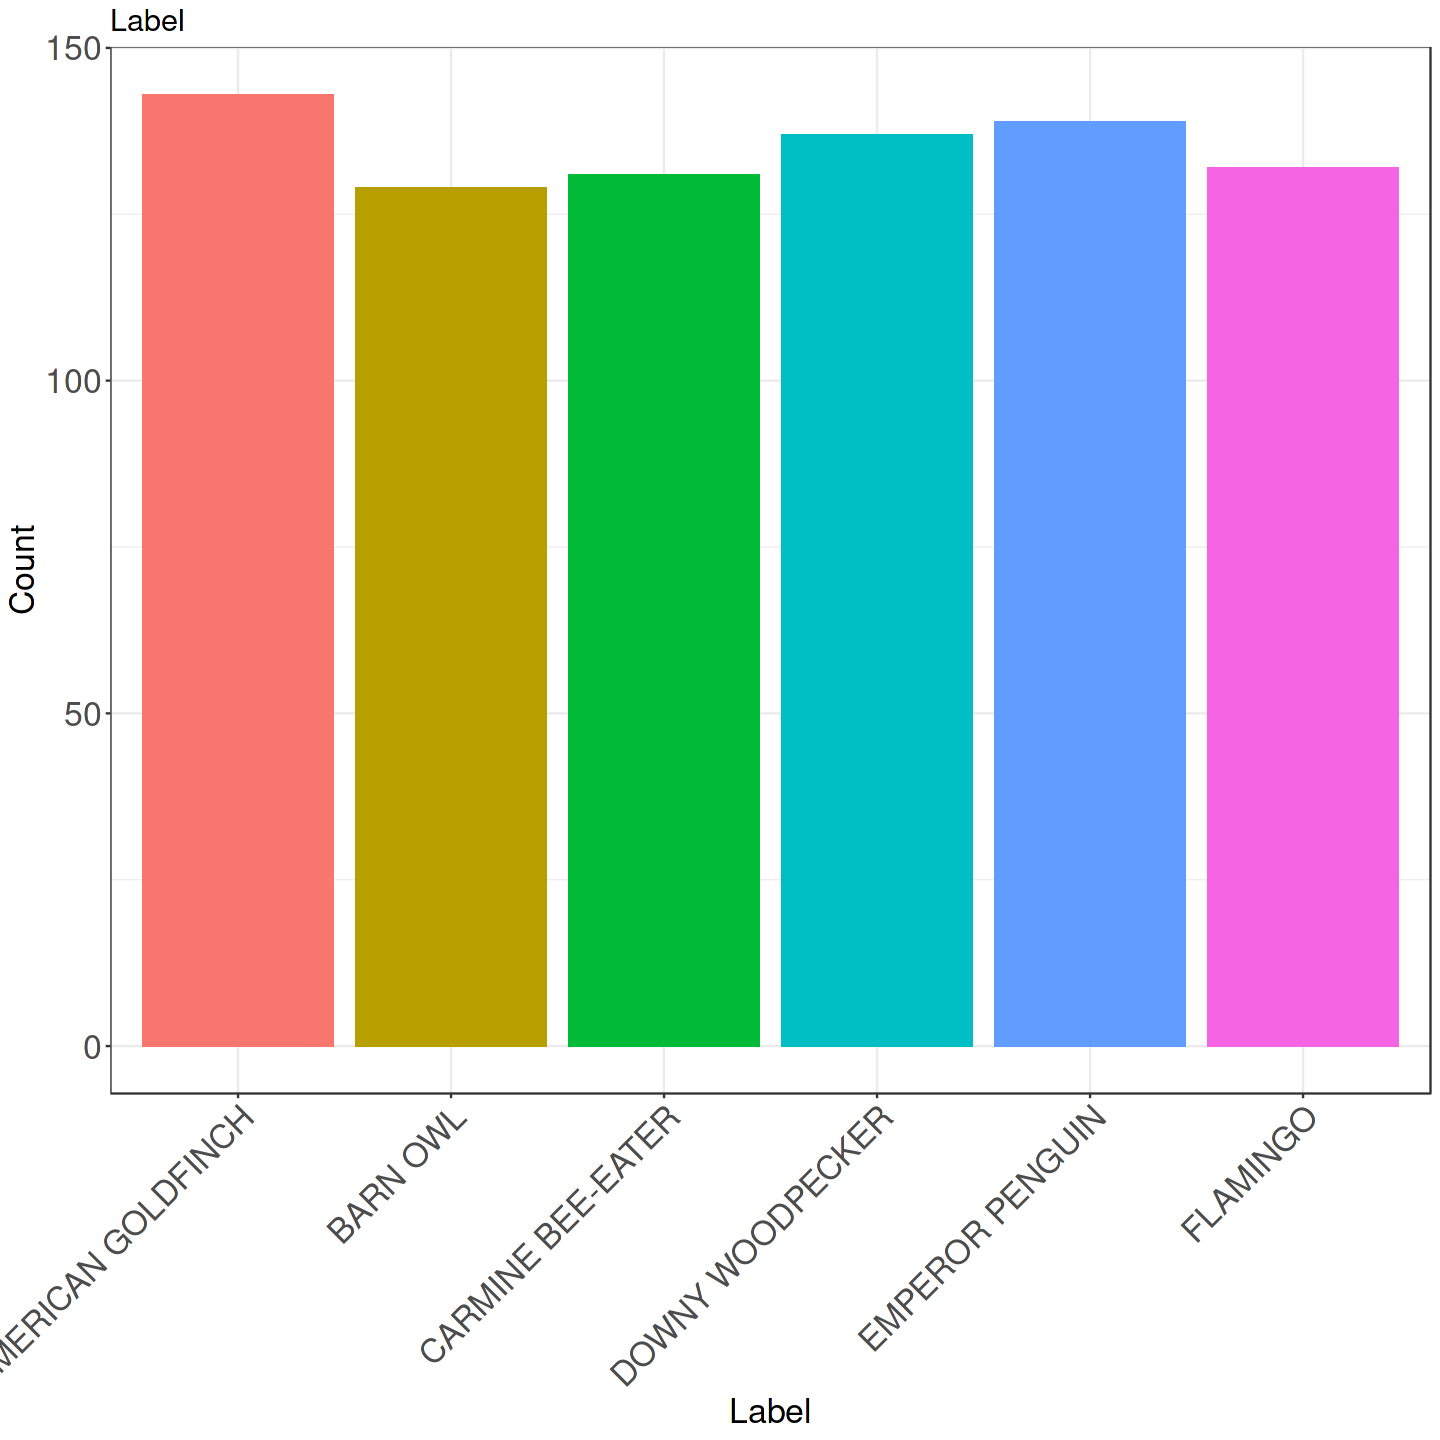

In [11]:
options(repr.plot.width = 12.0, repr.plot.height = 12.0)

ggplot(all_data) +
  geom_bar(aes(x = label, fill = label)) +
  theme_bw()+
  labs(title = "Label",
       x = "Label",
       y = "Count") +
        theme(
        legend.position = 'none',
        axis.title = element_text(size=20),
        axis.text.x = element_text(size = 20, hjust=1, angle = 45),
        axis.text.y = element_text(size = 20),
        title = element_text(size=15)
        ) 

# **3. Modeling**

## **Resnet50**

In [12]:
pre_trained_model <- application_resnet50_v2(
  weights = 'imagenet',
  input_shape = c(224, 224, 3),
  include_top = FALSE
)

In [13]:
for (layer in pre_trained_model$layers) {
  layer$trainable <- FALSE
}

In [14]:
set_trainable <- FALSE
for (layer in pre_trained_model$layers) {
  if (layer$name == 'conv5_block1_preact_bn') {
    set_trainable <- TRUE
  }
  layer$trainable <- set_trainable
}


In [15]:
model <- keras_model_sequential() %>%
  pre_trained_model %>%
  layer_global_average_pooling_2d() %>%
  layer_dense(units = 1024, activation = 'relu') %>%
  layer_dense(units = num_classes, activation = 'softmax')

model %>% compile(
  optimizer = optimizer_adam(lr = 0.0001),
  loss = 'categorical_crossentropy',
  metrics = 'accuracy'
)

In [16]:
callbacks <- list(
  callback_model_checkpoint(filepath = 'best_model.h5', save_best_only = TRUE),
  callback_early_stopping(monitor = "val_loss", patience = 5, restore_best_weights = TRUE),
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.5, patience = 3, min_lr = 1e-6)
)

start_time <- Sys.time()

history <- model %>% fit(
  train_gen,
  validation_data = val_gen,
  epochs = 50,
  class_weight = class_weights,
  callbacks = callbacks
)

end_time <- Sys.time()
training_time_model_resnet50v2 <- end_time - start_time

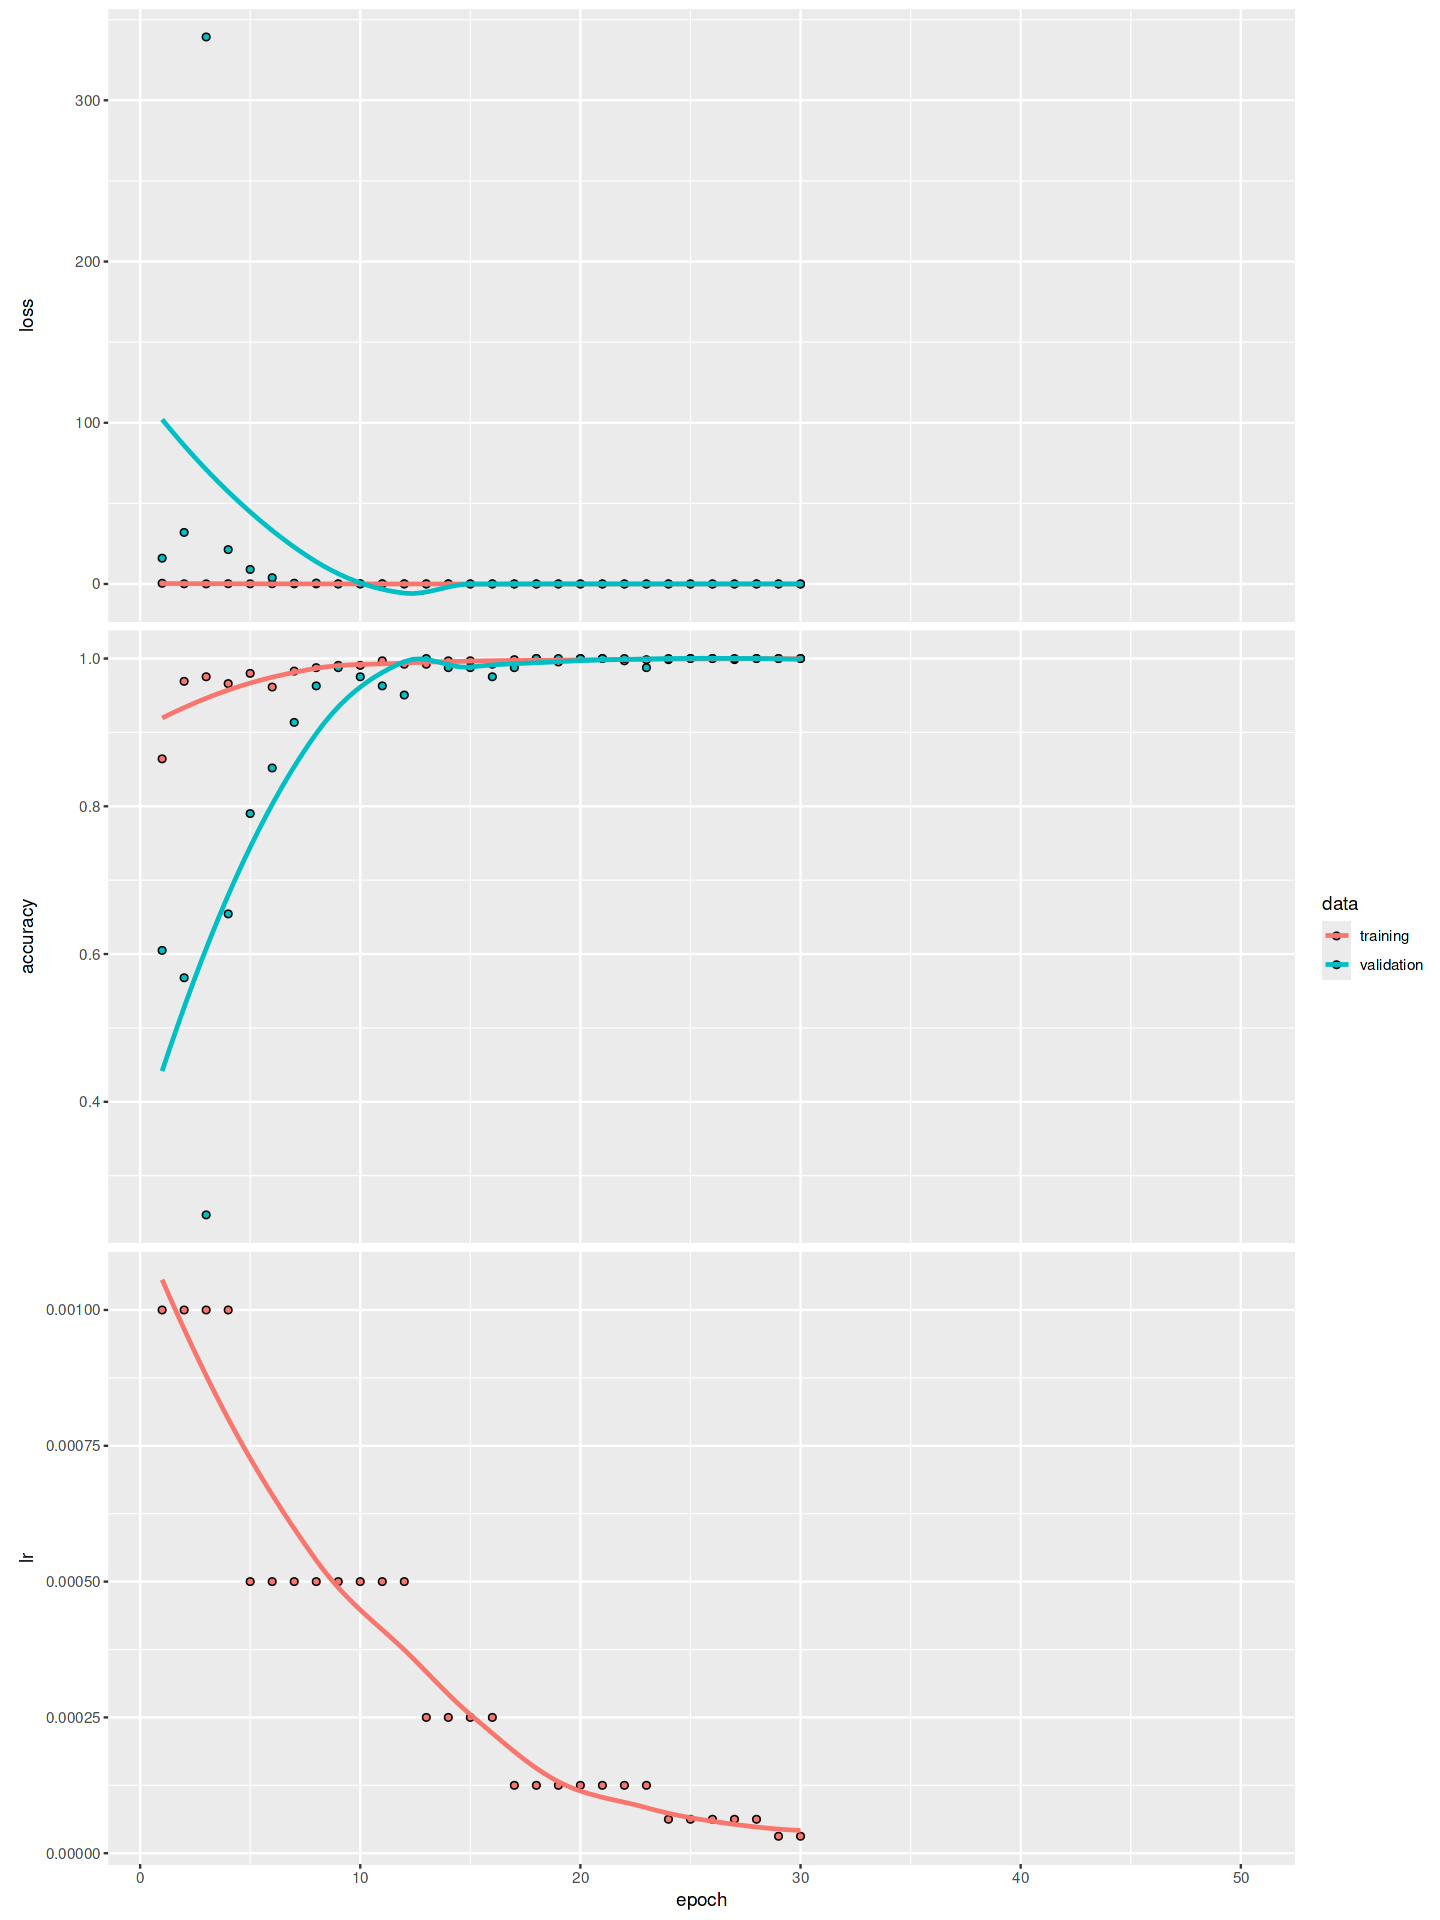

In [19]:
options(repr.plot.width = 12.0, repr.plot.height = 16.0)
plot(history)

## **Evaluation**

### **Confusion matrix**

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3  4  5
         0 13  0  0  0  0  0
         1  0 14  0  0  0  0
         2  0  0 12  0  0  0
         3  0  0  0 17  0  0
         4  0  0  0  0 15  0
         5  0  0  0  0  0 11

Overall Statistics
                                    
               Accuracy : 1         
                 95% CI : (0.956, 1)
    No Information Rate : 0.2073    
    P-Value [Acc > NIR] : < 2.2e-16 
                                    
                  Kappa : 1         
                                    
 Mcnemar's Test P-Value : NA        

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity            1.0000   1.0000   1.0000   1.0000   1.0000   1.0000
Specificity            1.0000   1.0000   1.0000   1.0000   1.0000   1.0000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000   1.0000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000   

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC for Class 1 : 1 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC for Class 2 : 1 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC for Class 3 : 1 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC for Class 4 : 1 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC for Class 5 : 1 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC for Class 6 : 1 


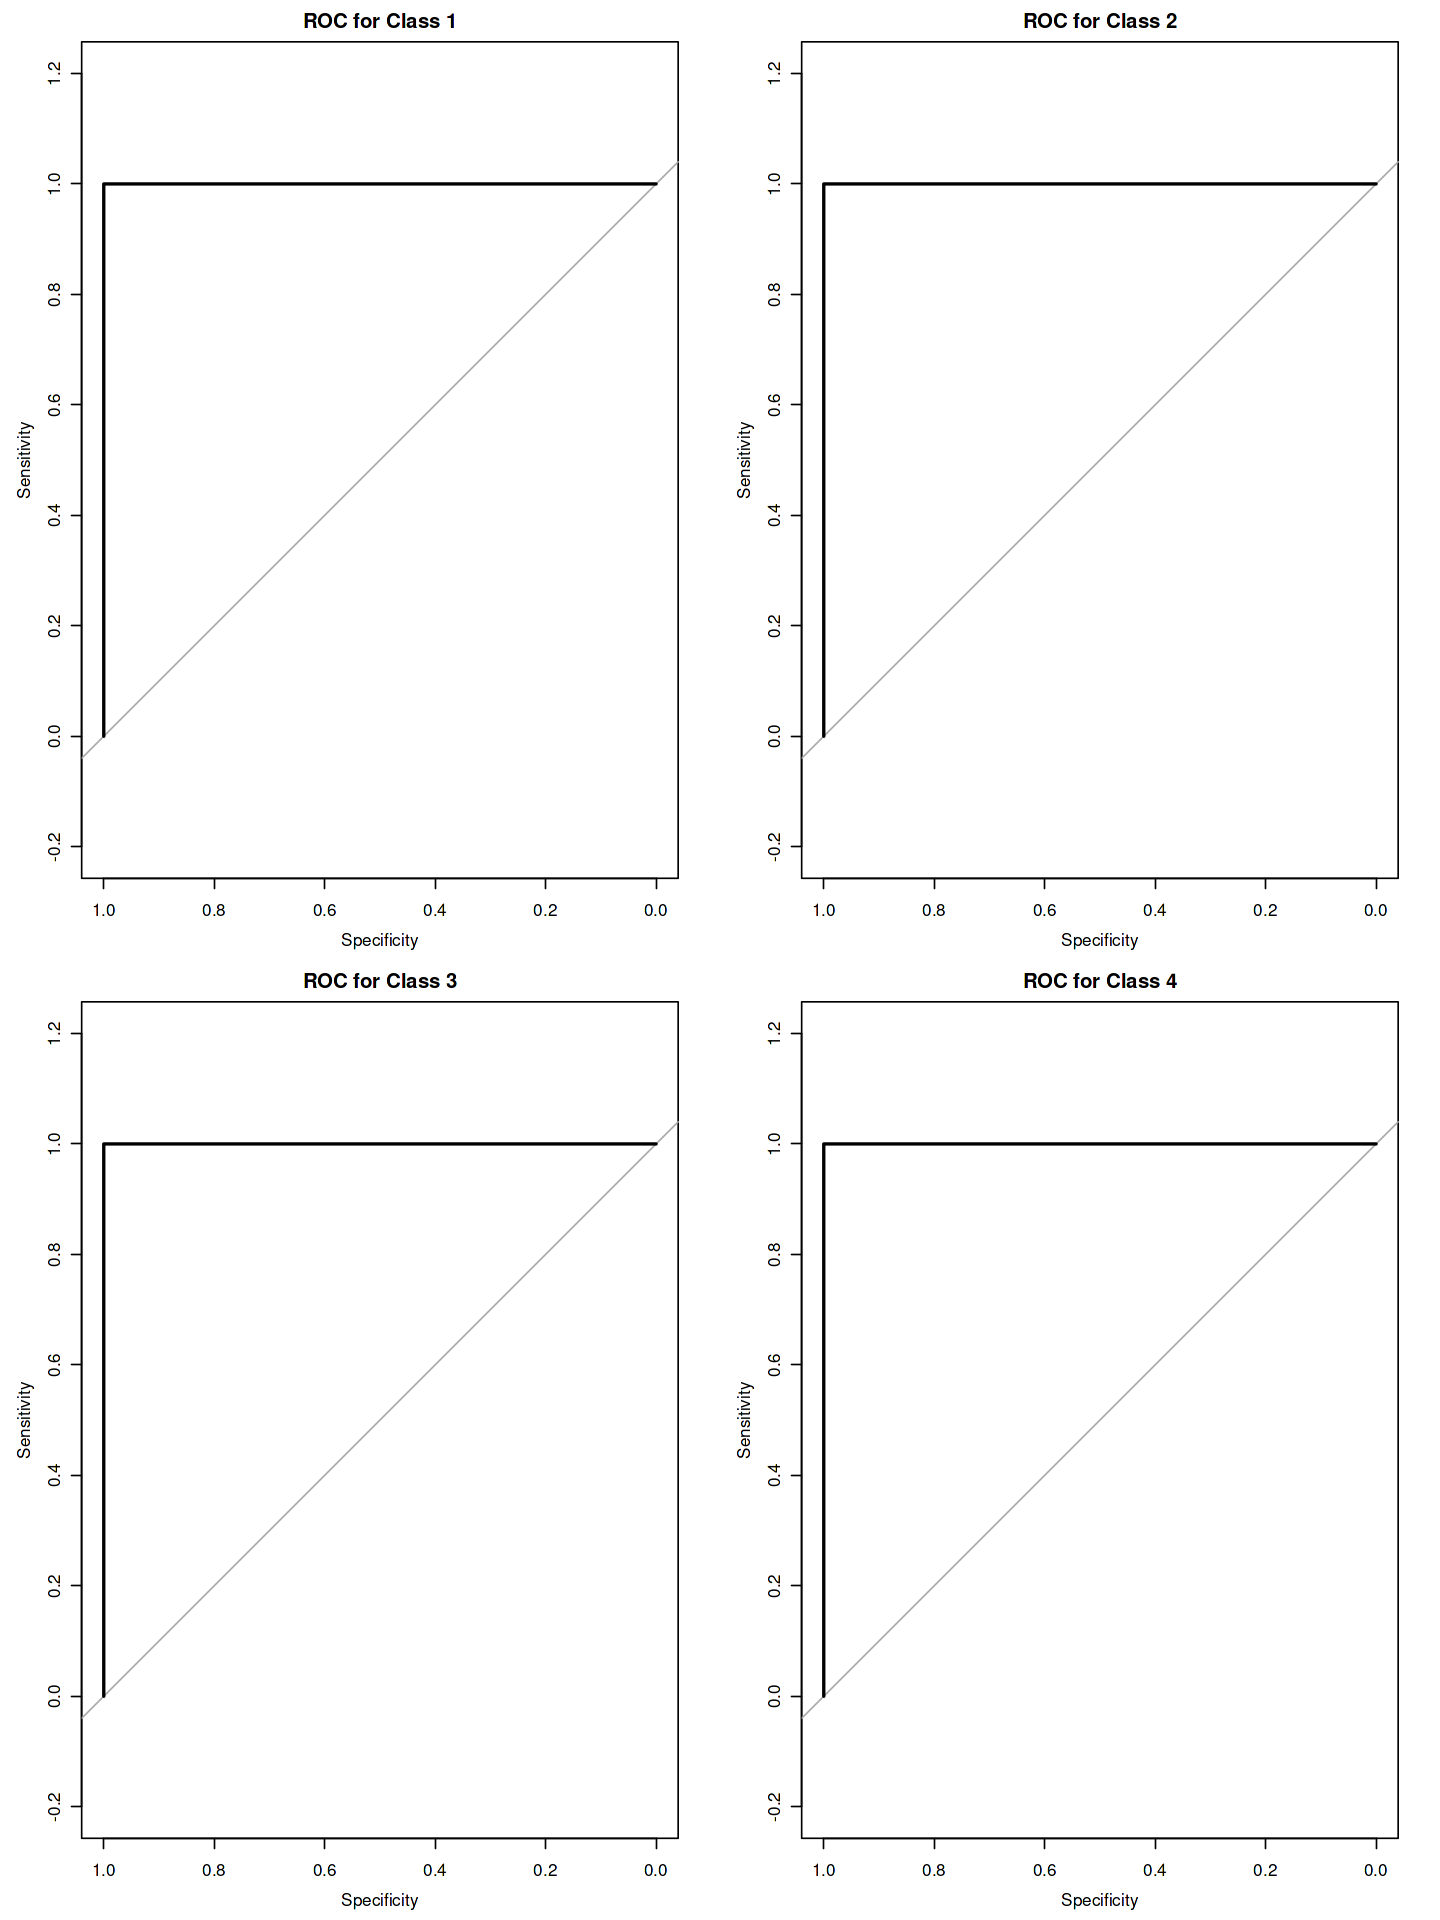

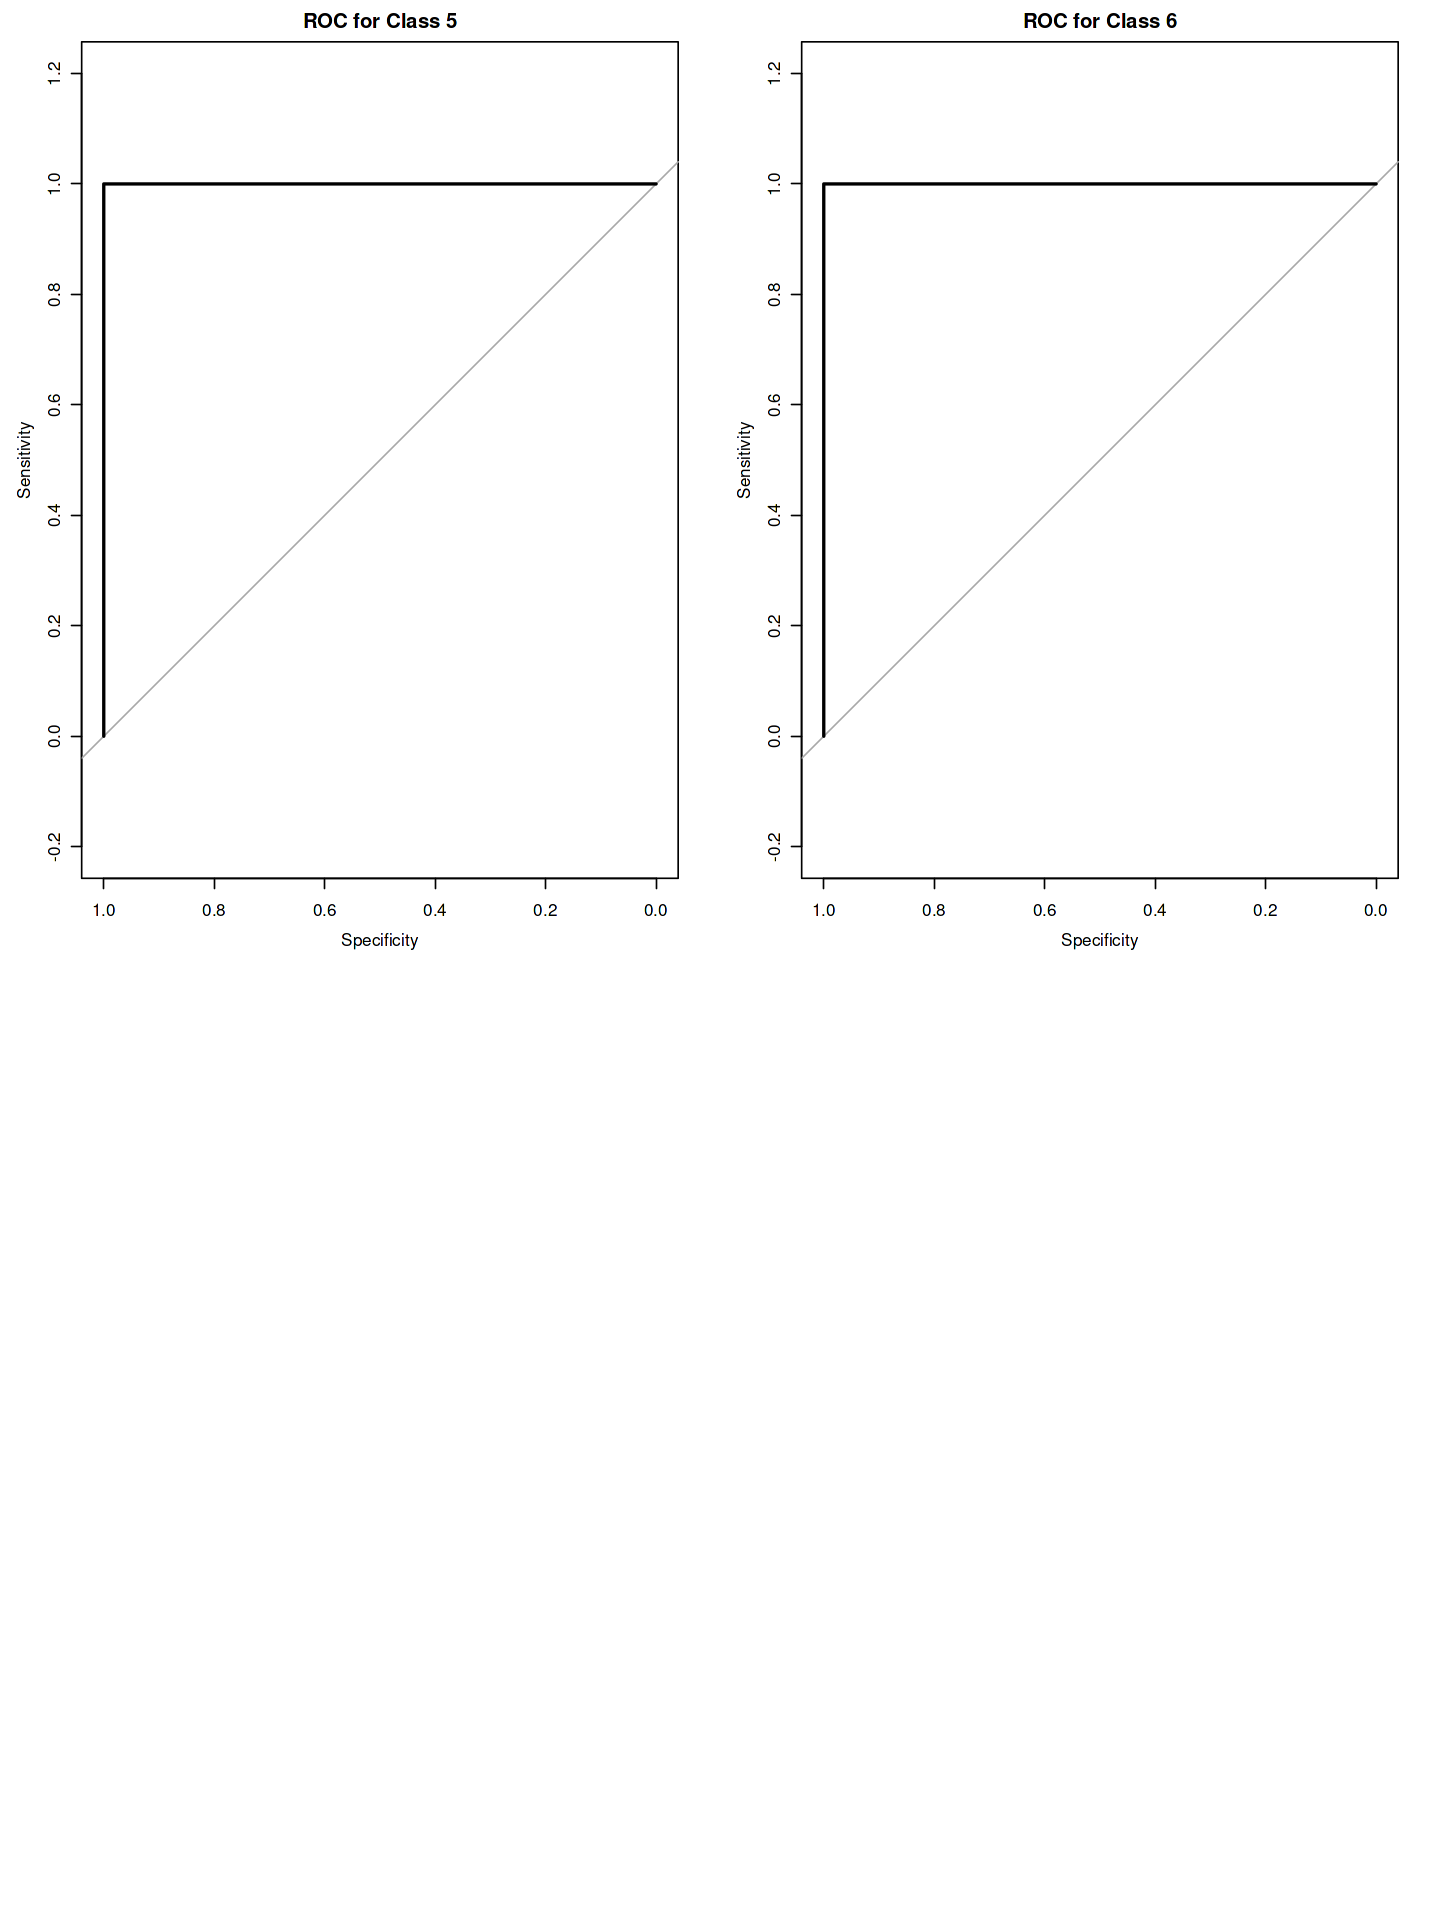

In [23]:
test_preds <- model %>% predict(test_gen, steps = ceiling(test_gen$n / batch_size))
test_preds_labels <- apply(test_preds, 1, which.max) - 1

test_true_labels <- c()
steps <- ceiling(test_gen$n / batch_size)
for (i in seq_len(steps)) {
  batch <- generator_next(test_gen)
  test_true_labels <- c(test_true_labels, apply(batch[[2]], 1, which.max) - 1)
}

conf_matrix <- confusionMatrix(as.factor(test_preds_labels), as.factor(test_true_labels))
print(conf_matrix)

test_true_labels_matrix <- to_categorical(test_true_labels, num_classes = num_classes)

par(mfrow = c(2, 2)) 

auc_values <- numeric(num_classes)
for (i in 1:num_classes) {
  roc_curve <- roc(test_true_labels_matrix[, i], test_preds[, i])
  plot(roc_curve, main = paste("ROC for Class", i))
  auc_value <- auc(roc_curve)
  auc_values[i] <- auc_value
  cat("AUC for Class", i, ":", auc(roc_curve), "\n")
}

auc_values_resnet50v2 <- auc_values

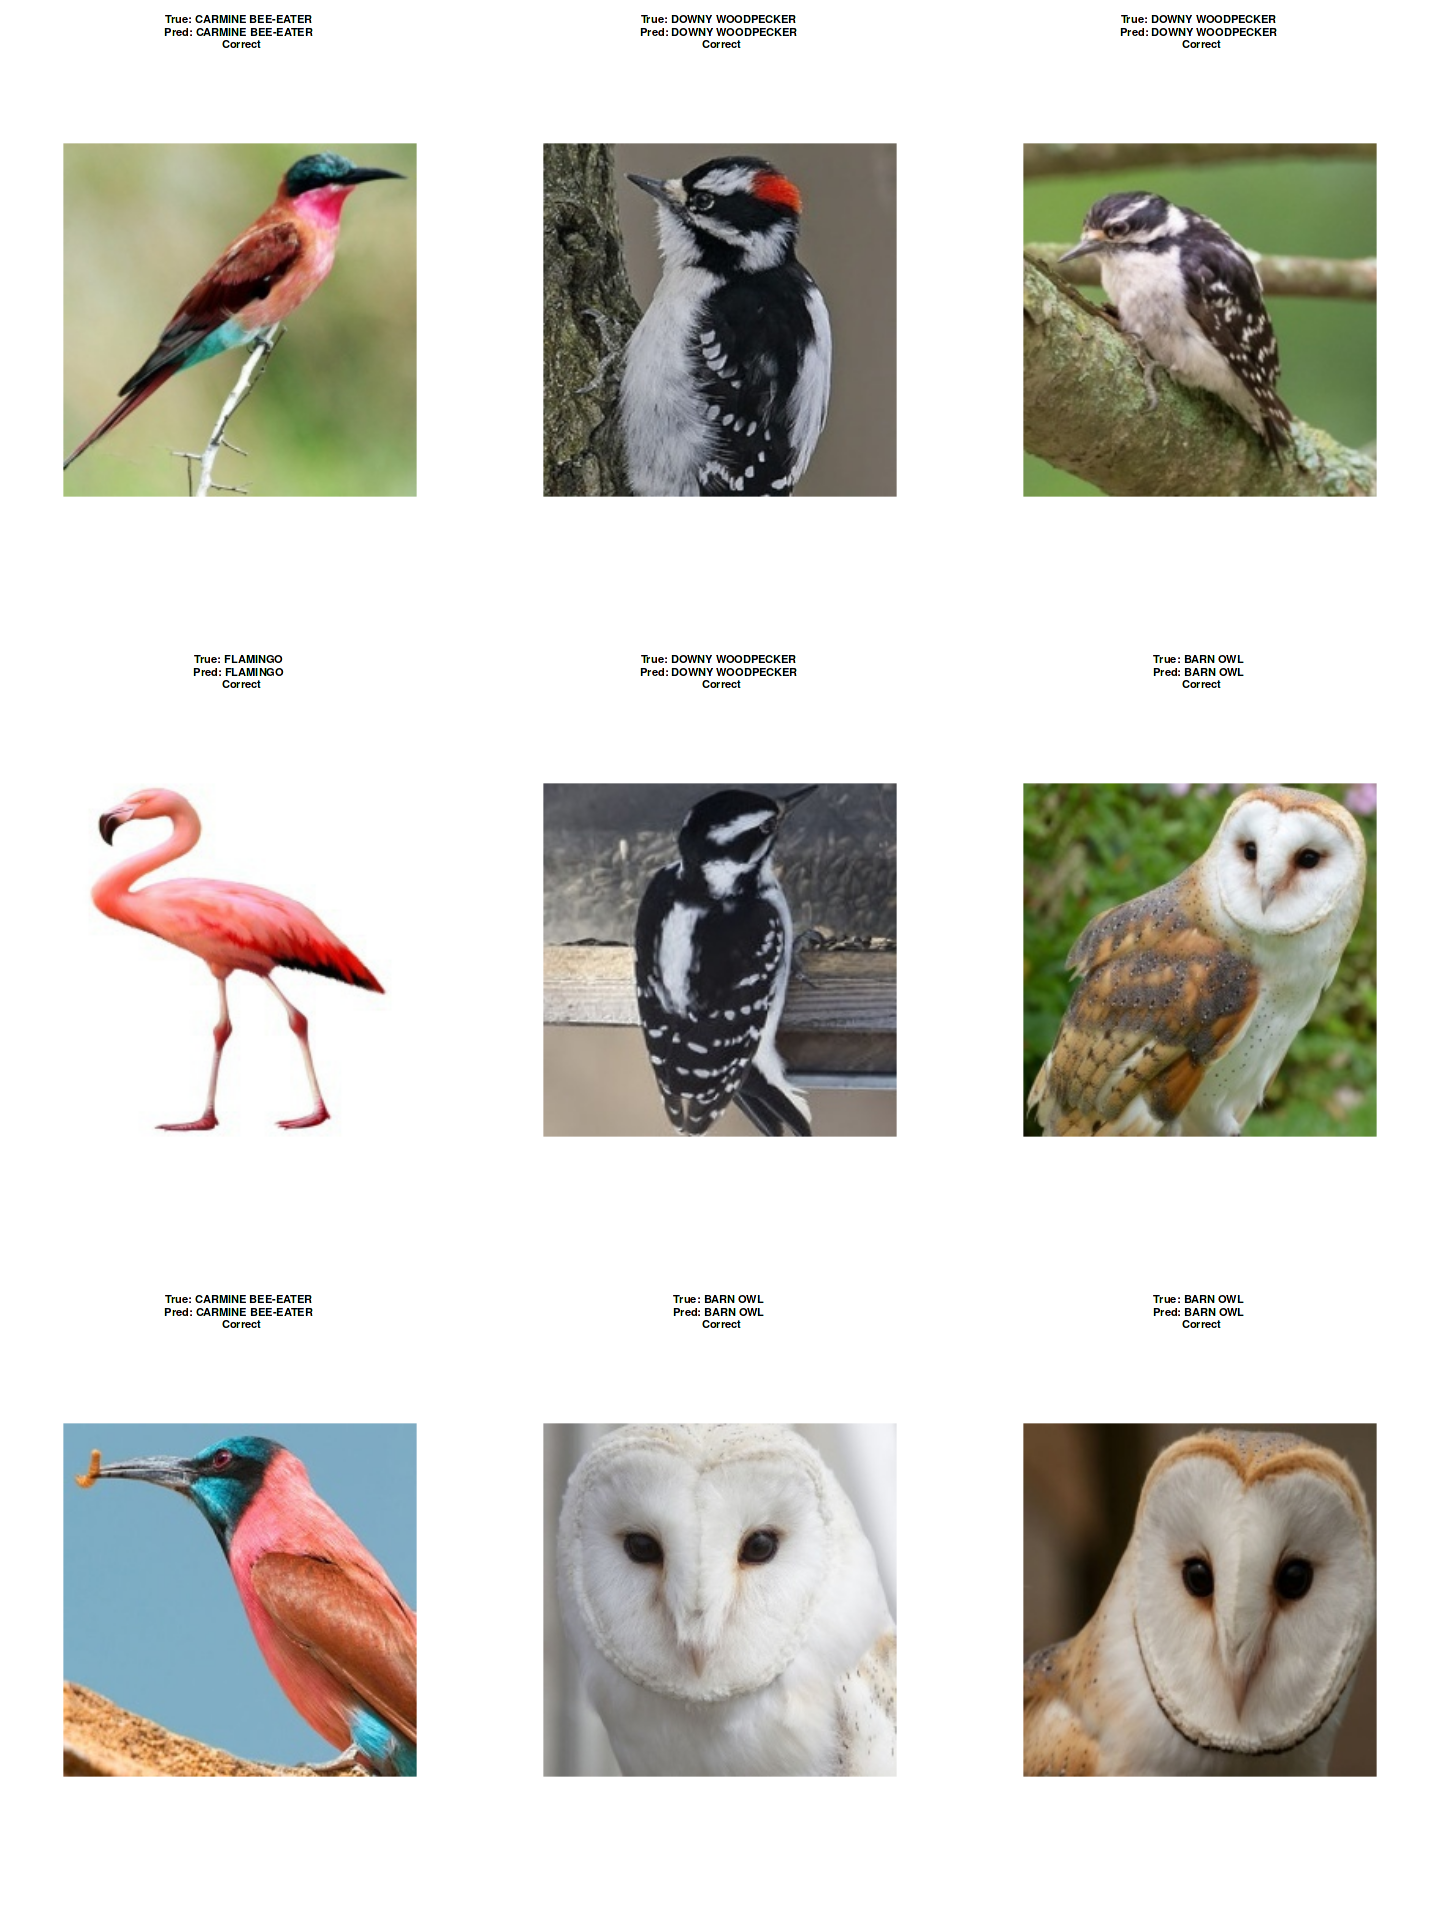

In [26]:
preprocess_image <- function(image_path, target_size) {
  img <- image_load(image_path, target_size = target_size)
  img_array <- image_to_array(img) / 255
  img_array <- array_reshape(img_array, c(1, target_size[1], target_size[2], 3))
  return(img_array)
}

plot_images_with_predictions <- function(image_paths, true_labels, predicted_labels, class_labels) {
  par(mfrow = c(3, 3), mar = c(4, 4, 4, 4)) 
  for (i in 1:length(image_paths)) {
    img <- image_load(image_paths[i], target_size = img_size)
    img_array <- image_to_array(img) / 255
    img_array <- array_reshape(img_array, c(img_size[1], img_size[2], 3))
    true_label <- class_labels[true_labels[i] + 1]
    predicted_label <- class_labels[predicted_labels[i] + 1]
    correct <- ifelse(true_labels[i] == predicted_labels[i], "Correct", "Incorrect")
    
    plot(as.raster(img_array))
    title(main = paste("True:", true_label, "\nPred:", predicted_label, "\n", correct), cex.main = 0.8)
  }
}

set.seed(123)
random_indices <- sample(1:nrow(test_data), 9)
random_test_data <- test_data[random_indices, ]
random_image_paths <- random_test_data$file_path

true_labels <- random_test_data$label
class_indices <- train_gen$class_indices
class_labels <- names(class_indices)
true_labels <- match(true_labels, class_labels) - 1

predicted_labels <- c()
for (i in 1:length(random_image_paths)) {
  img_array <- preprocess_image(random_image_paths[i], img_size)
  prediction <- model %>% predict(img_array)
  predicted_label <- which.max(prediction) - 1
  predicted_labels <- c(predicted_labels, predicted_label)
}

plot_images_with_predictions(random_image_paths, true_labels, predicted_labels, class_labels)

correct_predictions <- sum(true_labels == predicted_labels)
total_predictions <- length(true_labels)
accuracy <- correct_predictions / total_predictions

In [28]:
model %>% evaluate_generator(test_gen, steps = 32)

Warning message in evaluate_generator(., test_gen, steps = 32):
“`evaluate_generator` is deprecated. Use `evaluate` instead, it now accept generators.”


loss     accuracy 
0.0007315903 1.0000000000

----------

**Please leave your advice in the comments. Thank you**